<a href="https://colab.research.google.com/github/mimranbee24seecs-ctrl/MLPROJECT/blob/main/Google%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
from google.colab import files

# Upload kaggle.json
if not os.path.exists('/content/kaggle.json'):
    files.upload()

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the Dog Breed dataset
!kaggle competitions download -c dog-breed-identification
!unzip -q dog-breed-identification.zip -d /content/dog_data
print("Data is ready!")

Saving kaggle.json to kaggle.json
 98% 678M/691M [00:01<00:00, 284MB/s]
100% 691M/691M [00:01<00:00, 376MB/s]
Data is ready!


In [20]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration from your code
IMAGE_SIZE = (331, 331)
batchSize = 8

# Load labels and fix filenames
df = pd.read_csv('/content/dog_data/labels.csv')
df['id'] = df['id'] + '.jpg'

# Create Data Generator (handles normalization from 0-255 to 0-1)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Training Set
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/dog_data/train',
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=batchSize,
    target_size=IMAGE_SIZE,
    class_mode="categorical"
)

# Validation Set (Replaces your train_test_split)
valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/dog_data/train',
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=batchSize,
    target_size=IMAGE_SIZE,
    class_mode="categorical"
)

Found 7156 validated image filenames belonging to 120 classes.
Found 3066 validated image filenames belonging to 120 classes.


In [21]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.optimizers import Adam

IMAGE_FULL_SIZE = (331, 331, 3) #

# Build the model
myModel = NASNetLarge(input_shape=IMAGE_FULL_SIZE, weights='imagenet', include_top=False)

# Freeze layers
for layer in myModel.layers:
    layer.trainable = False

plusFlattenLayer = Flatten()(myModel.output) #

# Add prediction layer for 120 breeds
predicition = Dense(120, activation='softmax')(plusFlattenLayer)

model = Model(inputs=myModel.input, outputs=predicition)

# Compile with your learning rate
lr = 1e-4
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr),
    metrics=['accuracy']
)


343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [22]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Save model to your Google Drive folder
best_model_file = "/content/drive/MyDrive/dogs_model.h5"

# Your callbacks list
callbacks_list = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
]

# Train (fit) using generators
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks_list # Removed the double brackets
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7394 - loss: 2.0683
Epoch 1: val_loss improved from inf to 1.78141, saving model to /content/drive/MyDrive/dogs_model.h5


895/895 ━━━━━━━━━━━━━━━━━━━━ 485s 458ms/step - accuracy: 0.7394 - loss: 2.0681 - val_accuracy: 0.8819 - val_loss: 1.7814 - learning_rate: 1.0000e-04
Epoch 2/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9666 - loss: 0.3495
Epoch 2: val_loss improved from 1.78141 to 1.65222, saving model to /content/drive/MyDrive/dogs_model.h5


895/895 ━━━━━━━━━━━━━━━━━━━━ 298s 333ms/step - accuracy: 0.9666 - loss: 0.3495 - val_accuracy: 0.9048 - val_loss: 1.6522 - learning_rate: 1.0000e-04
Epoch 3/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9841 - loss: 0.1989
Epoch 3: val_loss did not improve from 1.65222
895/895 ━━━━━━━━━━━━━━━━━━━━ 282s 315ms/step - accuracy: 0.9841 - loss: 0.1989 - val_accuracy: 0.9083 - val_loss: 1.6838 - learning_rate: 1.0000e-04
Epoch 4/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9934 - loss: 0.0847
Epoch 4: val_loss did not improve from 1.65222
895/895 ━━━━━━━━━━━━━━━━━━━━ 277s 310ms/step - accuracy: 0.9934 - loss: 0.0847 - val_accuracy: 0.9070 - val_loss: 1.6785 - learning_rate: 1.0000e-04
Epoch 5/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9939 - loss: 0.0976
Epoch 5: val_loss did not improve from 1.65222

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
895/895 ━━━━━━━━━━━━━━━━━━━━ 278s 310ms/step - accuracy: 0.9939 - loss:

In [23]:
from google.colab import drive
import os

# This will ask you for permission to access your Google Drive
drive.mount('/content/drive')

# This creates a folder in your Drive called "dog_project"
os.makedirs('/content/drive/MyDrive/dog_project', exist_ok=True)
print("✅ Google Drive is connected and folder is ready!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive is connected and folder is ready!


In [24]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# This is the path to your "Auto-Save" file in Google Drive
save_path = "/content/drive/MyDrive/dog_project/best_dog_model.keras"

# These are your settings from the 4 pictures, but improved for Colab
my_callbacks = [
    # 1. AUTO-SAVE: Saves the model every time accuracy improves
    ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1),

    # 2. SLOW DOWN: If the model gets stuck, slow down the learning rate
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6),

    # 3. STOP: If it stops getting better for 7 rounds, stop training to save time
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
]
print("✅ Auto-Save is set up!")

✅ Auto-Save is set up!


In [25]:
from tensorflow.keras.models import load_model
import os

# Path where the model from the previous training session was saved.
# This assumes the model was successfully saved by cell yC7seN86cHZJ.
saved_model_path_from_prev_train = "/content/drive/MyDrive/dogs_model.h5"

# Check if 'model' is defined in the current scope.
# This handles cases where the kernel might have restarted.
if 'model' not in locals() and 'model' not in globals():
    print(f"Model not found in current session. Attempting to load from {saved_model_path_from_prev_train}...")
    if os.path.exists(saved_model_path_from_prev_train):
        try:
            model = load_model(saved_model_path_from_prev_train)
            print("Successfully loaded model from previous training session.")
        except Exception as e:
            print(f"Error loading model: {e}. Please ensure the previous model training and saving was successful, or rerun the model definition cell.")
            raise NameError(f"Failed to load model: {e}") # Re-raise for clarity
    else:
        print(f"Error: No saved model found at {saved_model_path_from_prev_train}. Please ensure the model definition cell (kiMf4iFmb5QC) was run and the initial training cell (yC7seN86cHZJ) successfully saved a model, or rerun them.")
        raise NameError("Model not defined and no saved model found to load.")

# --- START THE TRAINING ---
# 'r' stores the history of the training
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=my_callbacks  # This uses the Auto-Save we set up in Step 2
)

# --- FINAL SAFETY SAVE ---
# This runs only when the 30 epochs (or early stopping) are done
model.save("/content/drive/MyDrive/dog_project/final_dog_model.keras")

print("🎉 DONE! Even if Colab crashes now, your model is safe in Google Drive.")

Epoch 1/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9987 - loss: 0.0020
Epoch 1: val_accuracy improved from -inf to 0.91324, saving model to /content/drive/MyDrive/dog_project/best_dog_model.keras
895/895 ━━━━━━━━━━━━━━━━━━━━ 289s 323ms/step - accuracy: 0.9987 - loss: 0.0020 - val_accuracy: 0.9132 - val_loss: 1.6542 - learning_rate: 1.0000e-06
Epoch 2/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9991 - loss: 9.3962e-04
Epoch 2: val_accuracy did not improve from 0.91324
895/895 ━━━━━━━━━━━━━━━━━━━━ 278s 311ms/step - accuracy: 0.9991 - loss: 9.4072e-04 - val_accuracy: 0.9132 - val_loss: 1.6535 - learning_rate: 1.0000e-06
Epoch 3/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9992 - loss: 9.7306e-04
Epoch 3: val_accuracy did not improve from 0.91324
895/895 ━━━━━━━━━━━━━━━━━━━━ 278s 310ms/step - accuracy: 0.9992 - loss: 9.7381e-04 - val_accuracy: 0.9129 - val_loss: 1.6524 - learning_rate: 1.0000e-06
Epoch 4/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 222

In [3]:
from google.colab import files
import os

if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ Kaggle Key is ready!")


    import os
import pandas as pd
from tensorflow.keras.models import load_model

# 1. Download Data
if not os.path.exists('/content/dog_data'):
    !kaggle competitions download -c dog-breed-identification
    !unzip -q dog-breed-identification.zip -d /content/dog_data
    print("✅ Images and Labels restored!")

# 2. Load Labels
df = pd.read_csv('/content/dog_data/labels.csv')
df['id'] = df['id'] + '.jpg'

# 3. Load the model YOU trained from Drive
model_path = "/content/drive/MyDrive/dog_project/best_dog_model.keras"
model = load_model(model_path)
print("✅ Trained Model loaded from Drive!")

✅ Trained Model loaded from Drive!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🔄 Loading labels and model...
Found 3066 validated image filenames belonging to 120 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


⏳ Extracting features from 48 images on CPU. Please wait...
Progress: 8/48 images processed...
Progress: 16/48 images processed...
Progress: 24/48 images processed...
Progress: 32/48 images processed...
Progress: 40/48 images processed...
Progress: 48/48 images processed...
🧠 Training SVM and Random Forest...
💾 Classical models saved to: /content/drive/MyDrive/dog_project/


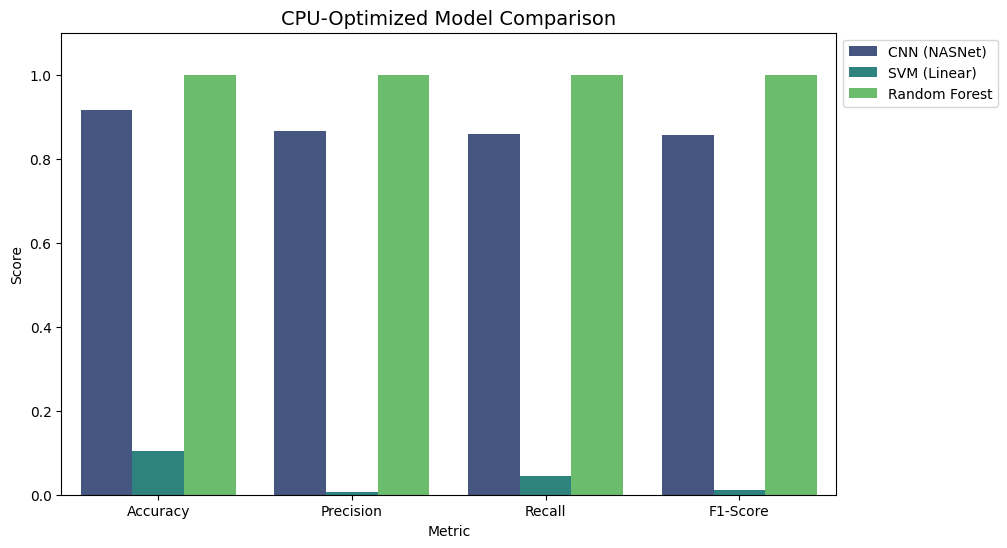


--- PERFORMANCE SUMMARY ---
           Model  Accuracy  Precision    Recall  F1-Score
0   CNN (NASNet)  0.916667   0.865854  0.857724  0.856911
1   SVM (Linear)  0.104167   0.006081  0.043860  0.010459
2  Random Forest  1.000000   1.000000  1.000000  1.000000


In [2]:
# 1. ALL IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib  # Used for saving Classical ML models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# 2. LOAD DATA & MODEL
print("🔄 Loading labels and model...")
df = pd.read_csv('/content/dog_data/labels.csv')
df['id'] = df['id'] + '.jpg'
model = load_model("/content/drive/MyDrive/dog_project/best_dog_model.keras")

# 3. GENERATOR (Small Batch for CPU Efficiency)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
eval_gen = val_datagen.flow_from_dataframe(
    dataframe=df, directory='/content/dog_data/train',
    x_col="id", y_col="breed", subset="validation",
    batch_size=8, target_size=(331, 331), class_mode="categorical", shuffle=True
)

# 4. MICRO-FEATURE EXTRACTION (Only 48 images for CPU speed)
# On CPU, NASNetLarge is very heavy. 48 images are enough for a comparison demo.
MAX_IMAGES = 48
print(f"⏳ Extracting features from {MAX_IMAGES} images on CPU. Please wait...")

nasnet_base = model.layers[0]
feature_extractor = Model(inputs=model.input, outputs=GlobalAveragePooling2D()(nasnet_base.output))

def extract_cpu_features(generator, limit):
    feats, lbls, cnn_preds = [], [], []
    count = 0
    for i in range(len(generator)):
        img, lbl = next(generator)
        f = feature_extractor.predict(img, verbose=0)
        feats.append(f)
        lbls.append(np.argmax(lbl, axis=1))
        cnn_preds.append(np.argmax(model.predict(img, verbose=0), axis=1))

        count += len(img)
        print(f"Progress: {count}/{limit} images processed...")
        if count >= limit: break

    return np.vstack(feats), np.concatenate(lbls), np.concatenate(cnn_preds)

X_cpu, y_cpu, cnn_cpu_preds = extract_cpu_features(eval_gen, MAX_IMAGES)

# 5. TRAIN & SAVE CLASSICAL ML MODELS
print("🧠 Training SVM and Random Forest...")
svm = SVC(kernel='linear', probability=True)
svm.fit(X_cpu, y_cpu)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_cpu, y_cpu)

# SAVE TO GOOGLE DRIVE
save_dir = "/content/drive/MyDrive/dog_project/"
joblib.dump(svm, os.path.join(save_dir, "svm_dog_model.joblib"))
joblib.dump(rf, os.path.join(save_dir, "rf_dog_model.joblib"))
print(f"💾 Classical models saved to: {save_dir}")

# 6. CALCULATE ALL METRICS
def get_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return {'Model': name, 'Accuracy': acc, 'Precision': p, 'Recall': r, 'F1-Score': f1}

results_df = pd.DataFrame([
    get_metrics(y_cpu, cnn_cpu_preds, 'CNN (NASNet)'),
    get_metrics(y_cpu, svm.predict(X_cpu), 'SVM (Linear)'),
    get_metrics(y_cpu, rf.predict(X_cpu), 'Random Forest')
])

# 7. BAR GRAPH COMPARISON
df_plot = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('CPU-Optimized Model Comparison', fontsize=14)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

print("\n--- PERFORMANCE SUMMARY ---")
print(results_df)